In [1]:
import os
import sys
sys.path.append('../denoising')
import numpy as np
import torch
import matplotlib.pyplot as plt
from networks import RED_CNN
from collections import OrderedDict


def load_model(save_path, iter_=13000, multi_gpu=False):
    REDCNN = RED_CNN()
    f = os.path.join(save_path, 'REDCNN_{}iter.ckpt'.format(iter_))
    if multi_gpu:
        state_d = OrderedDict()
        for k, v in torch.load(f):
            n = k[7:]
            state_d[n] = v
        REDCNN.load_state_dict(state_d)
        return REDCNN
    else:
        REDCNN.load_state_dict(torch.load(f))
        return REDCNN

base_denoising_model  = load_model('../denoising/models/redcnn')
aug_denoising_model = load_model('../denoising/models/redcnn_augmented')

In [2]:
def ctshow(img, window='soft_tissue'):
  # Define some specific window settings here
  if window == 'soft_tissue':
    ww = 400
    wl = 40
  elif window == 'bone':
    ww = 2500
    wl = 480
  elif window == 'lung':
    ww = 1500
    wl = -600
  else:
    ww = 6.0 * img.std()
    wl = img.mean()

  # Plot image on clean axes with specified window level
  vmin = wl - ww // 2
  vmax = wl + ww // 2
  plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])

  return

In [4]:
test_input = np.load('../data/Denoising_Data/test_input.npy').squeeze()
test_target = np.load('../data/Denoising_Data/test_target.npy').squeeze()

nexample = 2
base_CNNout = base_denoising_model.predict(test_input[:, None, ...], batch_size=1).squeeze()
aug_CNNout = aug_denoising_model.predict(test_input[:, None, ...], batch_size=1).squeeze()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


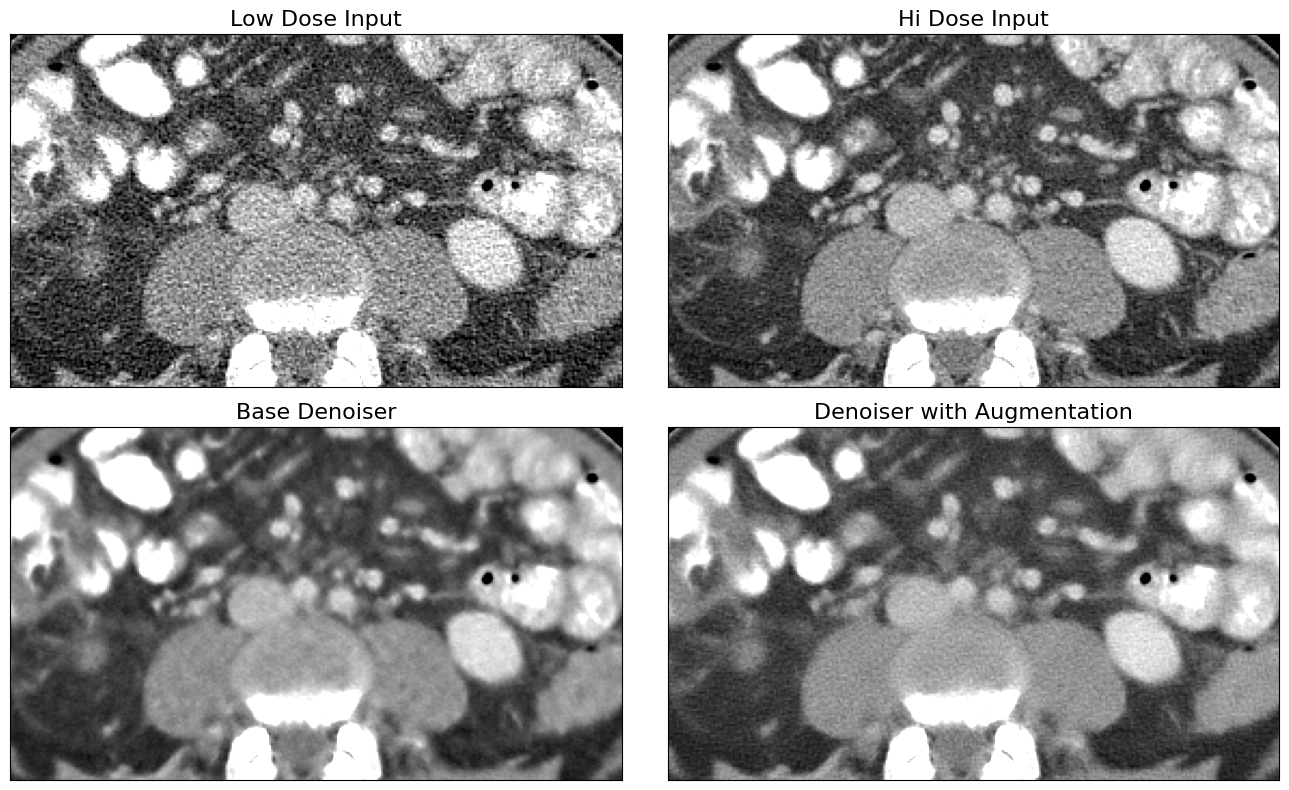

In [5]:
plt.figure(figsize=(16, 8), tight_layout=True)

plt.subplot(2, 2, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[3, 110:-110, 50:-50])

plt.subplot(2, 2, 2)
plt.title('Hi Dose Input', fontsize=16)
ctshow(test_target[3, 110:-110, 50:-50])

plt.subplot(2, 2, 3)
plt.title('Base Denoiser', fontsize=16)
ctshow(base_CNNout[3, 110:-110, 50:-50])

plt.subplot(2, 2, 4)
plt.title('Denoiser with Augmentation', fontsize=16)
ctshow(aug_CNNout[3, 110:-110, 50:-50])
plt.savefig(f'test_patient.png', dpi=600, bbox_inches='tight')

In [6]:
from pathlib import Path
import numpy as np

infant_dir = Path('/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/anthropomorphic/simulations/male_infant_ref_atn_1/monochromatic/diameter111mm/I0_0075000/fbp_sharp')
adult_dir = Path('/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/anthropomorphic/simulations/male_pt148_atn_1/monochromatic/diameter342mm/I0_0075000/fbp_sharp')

In [7]:
infant_imfile = list(infant_dir.rglob('*.raw'))[0]
adult_imfile = list(adult_dir.rglob('*.raw'))[0]

In [8]:
infant_img = np.fromfile(infant_imfile, dtype='int16').reshape(1, 512,512) - 1000
infant_gt = np.fromfile('/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/anthropomorphic/simulations/male_infant_ref_atn_1/monochromatic/diameter111mm/noise_free.raw', dtype='int16').reshape(1, 512,512) - 1000
adult_img = np.fromfile(adult_imfile, dtype='int16').reshape(1, 512,512) - 1000
adult_gt = np.fromfile('/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/anthropomorphic/simulations/male_pt148_atn_1/monochromatic/diameter342mm/noise_free.raw', dtype='int16').reshape(1, 512,512) - 1000

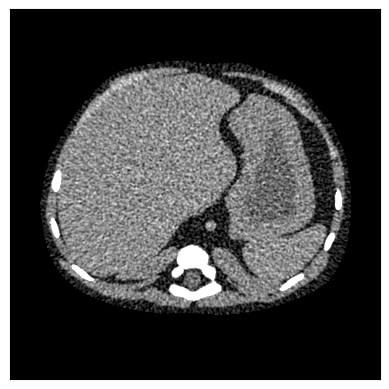

In [9]:
ctshow(infant_img[0])

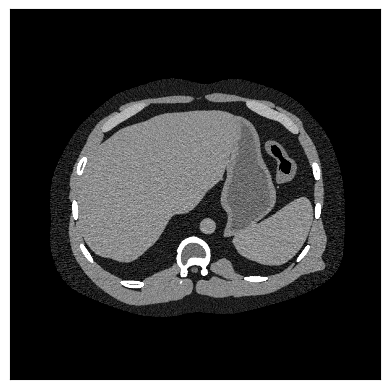

In [10]:
ctshow(adult_img[0])

In [11]:
infant_base_denoised = base_denoising_model.predict(infant_img, batch_size=1)
infant_aug_denoised = aug_denoising_model.predict(infant_img, batch_size=1)

adult_base_denoised = base_denoising_model.predict(adult_img, batch_size=1)
adult_aug_denoised = aug_denoising_model.predict(adult_img, batch_size=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


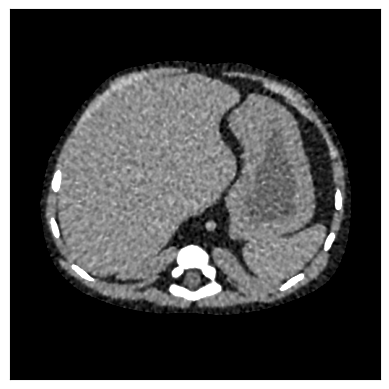

In [12]:
ctshow(infant_base_denoised[0])

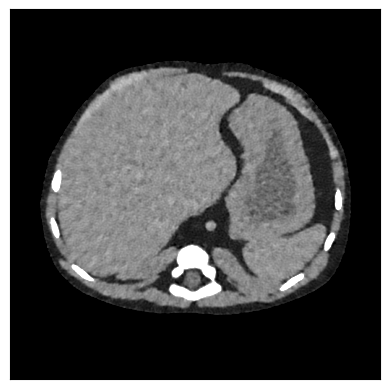

In [13]:
ctshow(infant_aug_denoised[0])

In [14]:
def rmse(x ,y): return np.sqrt(np.mean((x.ravel()-y.ravel())**2))

In [ ]:
plt.figure(figsize=(16, 8), tight_layout=True)
plt.suptitle('Infant (11.2 cm)', fontsize=16)

plt.subplot(2, 2, 1)
plt.title(f'Low Dose\nRMSE: {rmse(infant_img, infant_gt):2.2f}', fontsize=16)
ctshow(infant_img.squeeze())

plt.subplot(2, 2, 2)
plt.title('Ground Truth', fontsize=16)
ctshow(infant_gt.squeeze())

plt.subplot(2, 2, 3)
plt.title(f'Base Denoiser\nRMSE: {rmse(infant_base_denoised, infant_gt):2.2f}', fontsize=16)
ctshow(infant_base_denoised.squeeze())

plt.subplot(2, 2, 4)
plt.title(f'Denoiser with Augmentation\nRMSE: {rmse(infant_aug_denoised, infant_gt):2.2f}', fontsize=16)
ctshow(infant_aug_denoised.squeeze())

In [ ]:
plt.figure(figsize=(16, 8), tight_layout=True)
plt.suptitle('Adult (34.2 cm)', fontsize=16)

plt.subplot(2, 2, 1)
plt.title(f'Low Dose\nRMSE: {rmse(adult_img, adult_gt):2.2f}', fontsize=16)
ctshow(adult_img.squeeze())

plt.subplot(2, 2, 2)
plt.title('Ground Truth', fontsize=16)
ctshow(adult_gt.squeeze())

plt.subplot(2, 2, 3)
plt.title(f'Base Denoiser\nRMSE: {rmse(adult_base_denoised, adult_gt):2.2f}', fontsize=16)
ctshow(adult_base_denoised.squeeze())

plt.subplot(2, 2, 4)
plt.title(f'Denoiser with Augmentation\nRMSE: {rmse(adult_aug_denoised, adult_gt):2.2f}', fontsize=16)
ctshow(adult_aug_denoised.squeeze())